In [1]:
%matplotlib inline
import numpy as np
import rpy2
from rpy2.robjects import pandas2ri, r as rcall
from scipy.ndimage import convolve
from scipy import ndimage
import matplotlib.pyplot as plt
import pandas as pd
pandas2ri.activate()

from ipywidgets import interact, interactive, widgets, Layout, Button
from IPython.display import Audio, display

import sys
sys.path.append("..") # load package in parent folder
import load_r
load_r.load_rda(from_dir='../../results/')
balance = load_r.get_balance()
returns = load_r.get_returns()
returns_annualized_days = (1+returns)**365-1 #annualized returns

zlim, zrange = load_r.find_zlim(balance, center=1)

[load_rda] loading "/home/vhcandido/Documents/usp/research/performance/results/RSI/EURUSD_days_.rda"


In [2]:
from datetime import datetime
dates = np.array(rcall('as.character(bt$dates)'))
dates = np.array([datetime.strptime(d, '%Y-%m-%d') for d in dates])

def format_dates(dates, format='%Y-%m-%d'):
    return np.array([datetime.strftime(d, format) for d in dates])

def get_group_indexes(dates, format='%Y-%m'):
    formatted = format_dates(dates, format=format)
    clusters = []
    for cl in np.unique(formatted):
        idx = np.where(formatted == cl)[0]
        clusters.append(idx)
    return clusters

def apply_over_groups(x, groups, f, *args, **kwargs):
    return np.array([f(x[g], *args, **kwargs) for g in groups])

def format_all_returns(x):    
    groups = get_group_indexes(dates, '%Y-%m')
    return np.apply_along_axis(func1d=apply_over_groups,
                               axis=0, arr=x, groups=groups,
                               f=lambda x: np.prod(x+1)-1)

def format_all_balances(x):    
    groups = get_group_indexes(dates, '%Y-%m')
    return np.apply_along_axis(func1d=apply_over_groups,
                               axis=0, arr=x, groups=groups,
                               f=lambda x: x[-1])


returns_monthly = format_all_returns(returns)
returns_annualized_months = (returns_monthly+1)**12-1

balance_monthly = format_all_balances(balance)
returns_annualized_months = (balance_monthly+1)**12-1

In [14]:
months = np.unique(format_dates(dates, '%Y-%m'))
def get_interact(x):
    x = np.copy(x)
    def f(n, j, i):
        zlim, _ = load_r.find_zlim(x, 0)
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111)
        axi = ax.imshow(x[n, i[0]:i[1], j[0]:j[1]], vmin=zlim[0], vmax=zlim[1], cmap=plt.cm.jet)
        #ax.imshow(x[n], cmap=plt.cm.jet)
        ax.set_title(months[n])
        fig.colorbar(axi)
        plt.show()
    
    w1 = widgets.IntSlider(min=0, max=len(x)-1, step=1,
                           value=len(x)-1, description='Datetime',
                           continuous_update=False,
                           layout=Layout(width='80%', height='30px'))

    w2 = widgets.IntRangeSlider(min=0, max=x.shape[1]-1, step=1,
                                value=[0,x.shape[1]-1], description='Param 1',
                                continuous_update=False, layout=w1.layout)

    w3 = widgets.IntRangeSlider(min=0, max=x.shape[2]-1, step=1,
                                value=[0,x.shape[2]-1], description='Param 2',
                                continuous_update=False, layout=w1.layout)

    return interactive(f, n=w1, i=w3, j=w2)

w = get_interact(returns_monthly)

# Grouping returns

/home/vhcandido/anaconda3/envs/rpy/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


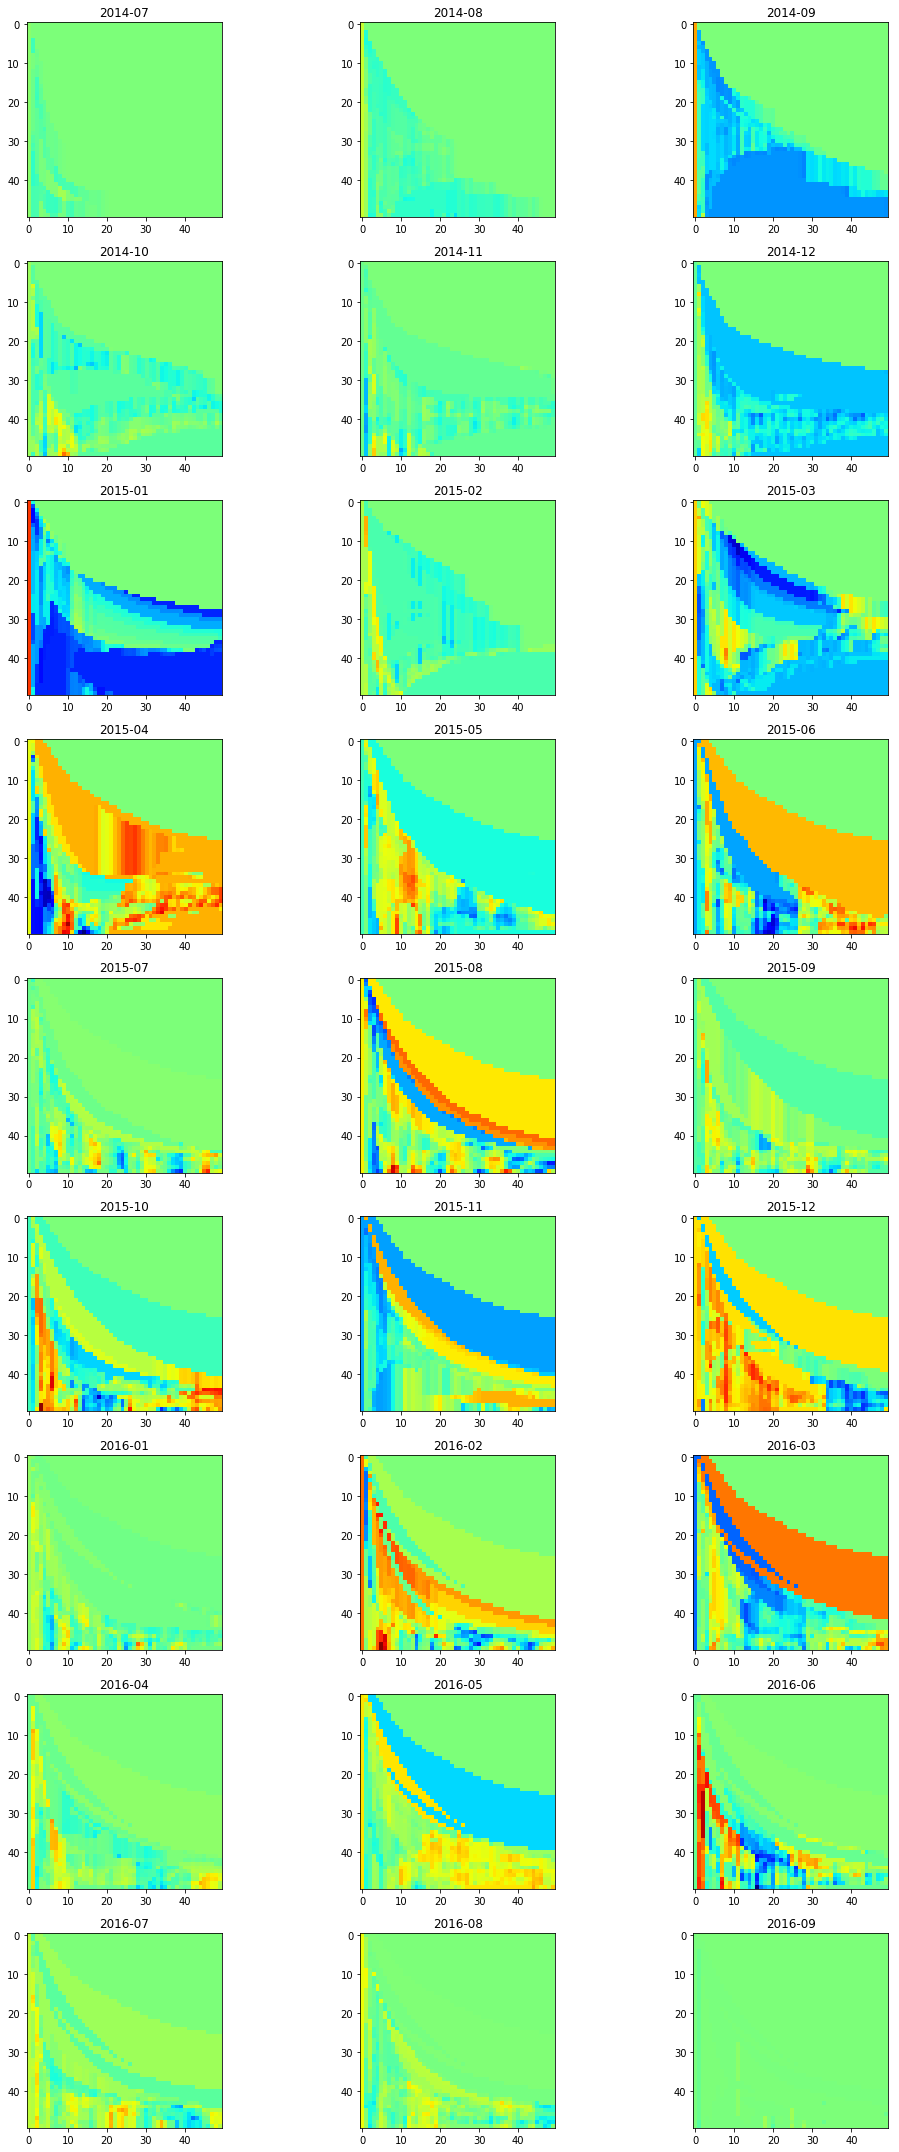

In [8]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(15,30), tight_layout=True)
row, col = 9, 3
gs = gridspec.GridSpec(row, col)
def plot(x, zlim=None):
    if zlim is None:
        zlim, _ = load_r.find_zlim(x, 0)
    for k, n in enumerate(range(len(x))):
        i = k // col
        j = k % col
        ax = fig.add_subplot(gs[i, j])
        #ax.imshow(returns_annualized_months[n], cmap = plt.cm.jet)
        ax.imshow(x[n], vmin=zlim[0], vmax=zlim[1], cmap=plt.cm.jet)
        ax.set_title(months[n])

plot(returns_monthly)
plt.show()

In [15]:
display(w)

interactive(children=(IntSlider(value=26, continuous_update=False, description='Datetime', layout=Layout(height='30px', width='80%'), max=26), IntRangeSlider(value=(0, 49), continuous_update=False, description='Param 1', layout=Layout(height='30px', width='80%'), max=49), IntRangeSlider(value=(0, 49), continuous_update=False, description='Param 2', layout=Layout(height='30px', width='80%'), max=49), Output()), _dom_classes=('widget-interact',))

# Image filters, convolutions

/home/vhcandido/anaconda3/envs/rpy/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


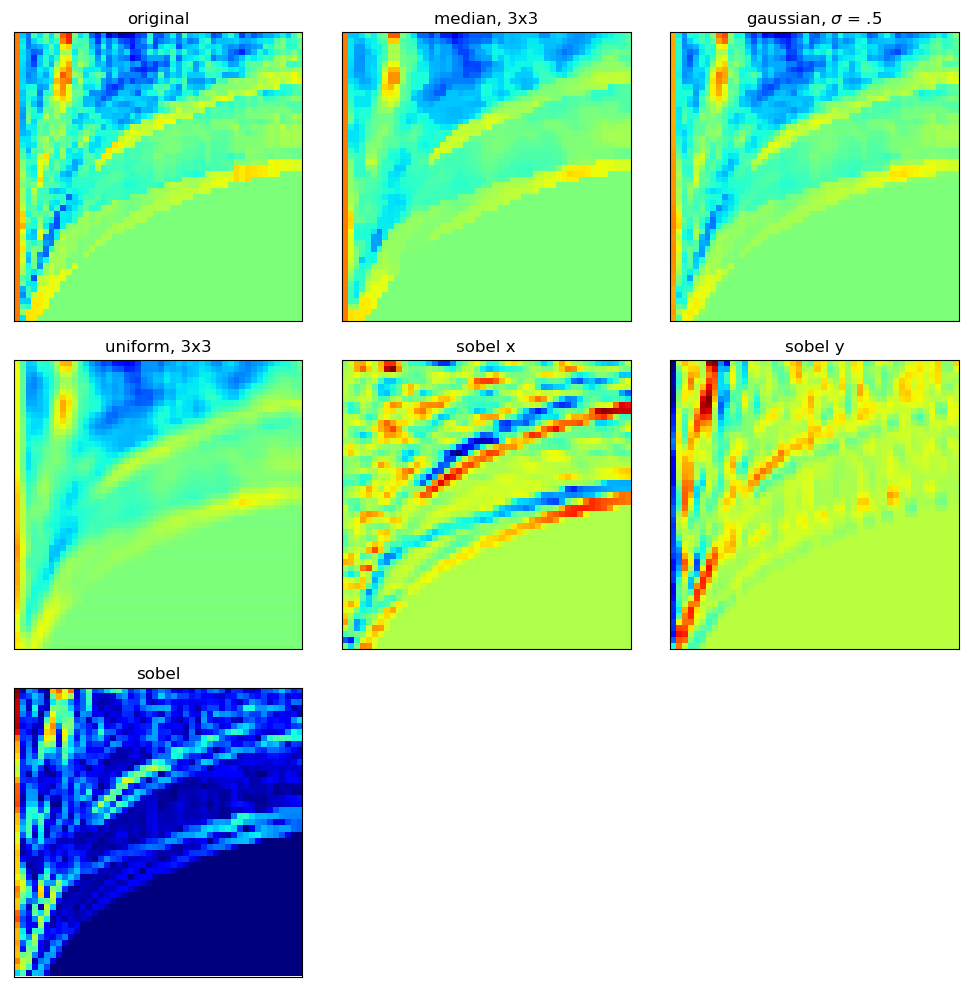

In [44]:
#http://www.scipy-lectures.org/advanced/image_processing/
b = np.copy(balance[-1])

fig = plt.figure(tight_layout=True, figsize=(10,10), dpi=100)
gs = gridspec.GridSpec(3, 3)

def plott(im, title, pos, col=3, center=True, cmap=plt.cm.jet):
    ax = fig.add_subplot(pos)
    if center:
        ax.imshow(im, origin='lower', cmap=cmap, vmin=zlim[0], vmax=zlim[1])
    else:
        #zlim2, _ = load_r.find_zlim(im)
        #plt.imshow(im, origin='lower', cmap=plt.cm.jet, vmin=zlim2[0], vmax=zlim2[1])
        ax.imshow(im, origin='lower', cmap=cmap)
    ax.set_title(title)
    ax.set_yticks([])
    ax.set_xticks([])

plott(b, 'original', gs[0,0])

im = ndimage.median_filter(b, 3)
plott(im, 'median, 3x3', gs[0,1])

im = ndimage.gaussian_filter(b, sigma=.5)
plott(im, 'gaussian, $\sigma$ = .5', gs[0,2])

im = ndimage.uniform_filter(b, size=3)
plott(im, 'uniform, 3x3', gs[1,0])

sx = ndimage.sobel(b, axis=0, mode='constant')
plott(sx[1:-1, 1:-1],  'sobel x', gs[1,1],center=False)

sy = ndimage.sobel(b, axis=1, mode='constant')
plott(sy[1:-1, 1:-1], 'sobel y', gs[1,2], center=False)

sob = np.hypot(sx, sy)
plott(sob[1:-1, 1:-1], 'sobel', gs[2,0], center=False)

#plt.subplots_adjust(wspace=0.02, hspace=0.5, top=.9, bottom=.1, left=.1, right=0.9)


# Clustering

In [23]:
def get_cluster_indexes(x, k = 5):
    from sklearn.cluster import KMeans
    kmeans = KMeans(n_clusters=k, random_state=0).fit(x.reshape(-1,1))
    clusters = []
    for cl in np.unique(kmeans.labels_):
        idx = np.where(kmeans.labels_ == cl)[0]
        clusters.append(idx)
    return clusters

def get_clusterized_array(x, clusters):
    print('cl |  mean | size')
    sorted_cl_idx = np.argsort([np.mean(x[idx]) for idx in clusters])
    for i, cl in enumerate(sorted_cl_idx):
        idx = clusters[cl]
        mean = np.mean(x[idx])
        x[idx] = mean
        print('%2d | %.3f | %d' % (i, mean, len(idx)))
    return x

def plot_k(k):
    b = np.copy(balance[-1].reshape(-1))
    cluster_idx_list = get_cluster_indexes(b, k)
    b = get_clusterized_array(b, cluster_idx_list)

    fig = plt.figure(dpi=100)
    ax = fig.add_subplot(111)
    img = ax.imshow(b.reshape(balance[-1].shape), cmap=plt.cm.jet, origin='lower', vmin=zlim[0], vmax=zlim[1])
    ax.set_title('k = %d' % k)
    fig.colorbar(img, ticks = np.unique(b))
    #plt.colorbar(img, cmap=cmap, norm=norm, boundaries=bounds, ticks=bounds)
    plt.show()

interact(plot_k, k=(1,10))

interactive(children=(IntSlider(value=5, description='k', max=10, min=1), Output()), _dom_classes=('widget-interact',))

<function __main__.plot_k>

# Return vs Risk

In [24]:
def semi_std(x, target=None):
    if target is None:
        target = np.mean(x)
    i = np.where(x < target)
    if len(x[i]) == 0: return 0.0
    return np.sqrt(np.sum((x[i] - target)**2)/len(x))

def semi_std_series(x_, target=None):
    l = []
    for i in np.arange(1, len(x_)+1):
        x = x_[np.arange(i)]
        if target is None:
            target = np.mean(x)
        i = np.where(x < target)
        if len(x[i]) == 0:
            l.append(0.0)
        else:
            l.append(np.sqrt(np.sum((x[i] - target)**2)/len(x)))
    return np.array(l)

def std_series(x_):
    l = []
    for i in np.arange(1, len(x_)+1):
        l.append(np.std(x_[np.arange(i)]))
    return np.array(l)

std_all1 = np.apply_along_axis(func1d=std_series, axis=0, arr=returns_monthly)
std_all2 = np.apply_along_axis(func1d=semi_std_series, axis=0, arr=returns_monthly, target=0)

b_annual = np.apply_along_axis(func1d=lambda x: x ** (12/int(x.shape[0]))-1, axis=0, arr=balance_monthly)

xlim, _ = load_r.find_zlim(b_annual, 0)
_, ylim1 = load_r.find_zlim(std_all1)
_, ylim2 = load_r.find_zlim(std_all2)

In [34]:
def scatter(i):
    fig = plt.figure(figsize=(10,8), dpi=100, tight_layout=True)
    
    ax = fig.add_subplot(211)
    sd1_ = std_all1[i]
    sd1_[np.where(sd1_ == 0)] = None
    ax.set_xlabel('Annualized ROR')
    ax.set_ylabel('stdev')
    ax.set_title(months[i])
    line1 = ax.scatter(b_annual[i], sd1_, s=15, alpha=.2)
    ax.set_xlim(xlim[0], xlim[1])
    ax.set_ylim(ylim1[0], ylim1[1])
    #line = ax.plot(balance[-1], sd1, 'bo', alpha=.1, markersize=3, picker=3)
    ax.grid(linestyle='--')

    ax = fig.add_subplot(212)
    sd2_ = std_all2[i]
    sd2_[np.where(sd2_ == 0)] = None
    line2 = ax.scatter(b_annual[i], sd2_, s=15, alpha=.2)
    ax.set_xlabel('Annualized ROR')
    ax.set_ylabel('semidev')
    ax.set_title(months[i])
    ax.set_xlim(xlim[0], xlim[1])
    ax.set_ylim(ylim2[0], ylim2[1])
    ax.grid(linestyle='--')
    
    plt.show()

x = widgets.IntSlider(min=0, max=len(std_all1)-1, step=1, value=len(std_all1)-1, continuous_update=False,
                     layout=Layout(width='80%'))
interact(scatter, i=x)

interactive(children=(IntSlider(value=26, continuous_update=False, description='i', layout=Layout(width='80%'), max=26), Output()), _dom_classes=('widget-interact',))

<function __main__.scatter>